In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

In [4]:
def show_images(images, titles):
    n = len(images)
    plt.figure(figsize=(10,10))
    for i in range(n):
        plt.subplot(1,n,i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

In [5]:
coco = COCO('../coco2014/annotations/instances_train2014.json')


loading annotations into memory...
Done (t=10.68s)
creating index...
index created!


In [11]:
movenet = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")

In [ ]:
image_dir = "../coco2014/images/train2014"

human_images_anns = []
blacklist = ["../coco2014/images/train2014/COCO_train2014_000000524291.jpg",
             "../coco2014/images/train2014/COCO_train2014_000000262191.jpg",
             "../coco2014/images/train2014/COCO_train2014_000000262171.jpg",
             "../coco2014/images/train2014/COCO_train2014_000000524317.jpg",
             "../coco2014/images/train2014/COCO_train2014_000000524325.jpg",
             "../coco2014/images/train2014/COCO_train2014_000000000049.jpg",
             "../coco2014/images/train2014/COCO_train2014_000000000061.jpg",

             ] #images that only include part of a person and should be excluded 
human_image_ids = set()
for ann in coco.anns.values():
    if ann['category_id'] == 1 and ann['iscrowd'] == 0: #human, not a crowd
        human_image_ids.add(ann['image_id'])
        human_images_anns.append(ann)
count = 0
human_image_paths = []
for img_id in human_image_ids:
    if(count < 20):
        img_info = coco.loadImgs(img_id)[0]
        img_path = f"{image_dir}/{img_info['file_name']}"
        if(img_path not in blacklist):
            human_image_paths.append(img_path)
            count+=1

print(len(human_image_paths))

{'segmentation': [[312.29, 562.89, 402.25, 511.49, 400.96, 425.38, 398.39, 372.69, 388.11, 332.85, 318.71, 325.14, 295.58, 305.86, 269.88, 314.86, 258.31, 337.99, 217.19, 321.29, 182.49, 343.13, 141.37, 348.27, 132.37, 358.55, 159.36, 377.83, 116.95, 421.53, 167.07, 499.92, 232.61, 560.32, 300.72, 571.89]], 'area': 54652.9556, 'iscrowd': 0, 'image_id': 480023, 'bbox': [116.95, 305.86, 285.3, 266.03], 'category_id': 58, 'id': 86}
20


In [13]:
keypoint_names = ['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder',
                  'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip',
                  'left_knee', 'right_knee', 'left_ankle', 'right_ankle']

connections = [(0, 1), (0, 2), (1, 3), (2, 4), (0, 5), (0, 6), (5, 7), (7, 9), (6, 8), (8, 10),
               (5, 6), (5, 11), (6, 12), (11, 12), (11, 13), (13, 15), (12, 14), (14, 16)]

def detect_pose_static(image_path):
    image = cv2.imread(image_path)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.equalizeHist(v)
    hsv_image = cv2.merge([h, s, v])
    final_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)

    image_resized = tf.image.resize_with_pad(tf.expand_dims(final_image, axis=0), 192, 192) #192 for lightning
    image_np = image_resized.numpy().astype(np.int32)
    outputs = movenet.signatures["serving_default"](tf.constant(image_np))
    keypoints = outputs['output_0'].numpy()

    original_image_resized = tf.image.resize_with_pad(tf.expand_dims(image, axis=0), 192, 192)
    original_image_np = original_image_resized.numpy().astype(np.int32)
    outputs = movenet.signatures["serving_default"](tf.constant(original_image_np))
    original_keypoints = outputs['output_0'].numpy()

    return keypoints,original_keypoints

def visualize_pose_static(image_path, keypoints, original_keypoints):
    image = cv2.imread(image_path)
    image_original = cv2.imread(image_path)
    keypoints = np.array(keypoints)
    original_keypoints = np.array(original_keypoints)
    if keypoints.shape == (1, 1, 17, 3):
        keypoints = keypoints[0, 0]
        for kp in keypoints:
            x = int(kp[1] * image.shape[1])
            y = int(kp[0] * image.shape[0])
            cv2.circle(image, (x, y), 12, (255, 0, 0), -1)  # Increase thickness and change color to blue
        for connection in connections:
            start_point = (int(keypoints[connection[0], 1] * image.shape[1]),
                           int(keypoints[connection[0], 0] * image.shape[0]))
            end_point = (int(keypoints[connection[1], 1] * image.shape[1]),
                         int(keypoints[connection[1], 0] * image.shape[0]))
            cv2.line(image, start_point, end_point, (0, 0, 255), 8)  # Increase thickness and change color to red
        
        original_keypoints = original_keypoints[0, 0]
        for kp in original_keypoints:
            x = int(kp[1] * image_original.shape[1])
            y = int(kp[0] * image_original.shape[0])
            cv2.circle(image_original, (x, y), 12, (255, 0, 0), -1)  # Increase thickness and change color to blue
        for connection in connections:
            start_point = (int(original_keypoints[connection[0], 1] * image_original.shape[1]),
                           int(original_keypoints[connection[0], 0] * image_original.shape[0]))
            end_point = (int(original_keypoints[connection[1], 1] * image_original.shape[1]),
                         int(original_keypoints[connection[1], 0] * image_original.shape[0]))
            cv2.line(image_original, start_point, end_point, (0, 0, 255), 8)  # Increase thickness and change color to red
        show_images([image_original,image],["Predicted Annotations without Processing","Predicted Annotations after Processing"])
    else:
        print("Unexpected shape of keypoints array:", keypoints.shape)

../coco2014/images/train2014/COCO_train2014_000000262145.jpg


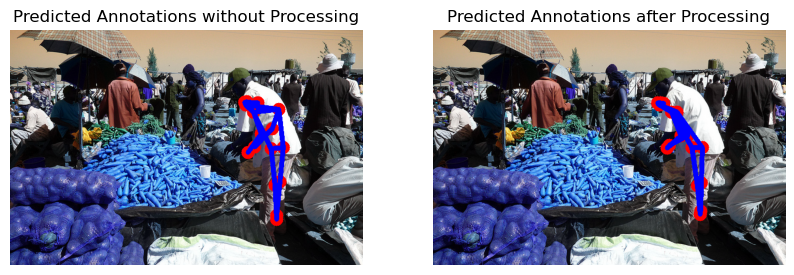

../coco2014/images/train2014/COCO_train2014_000000262146.jpg


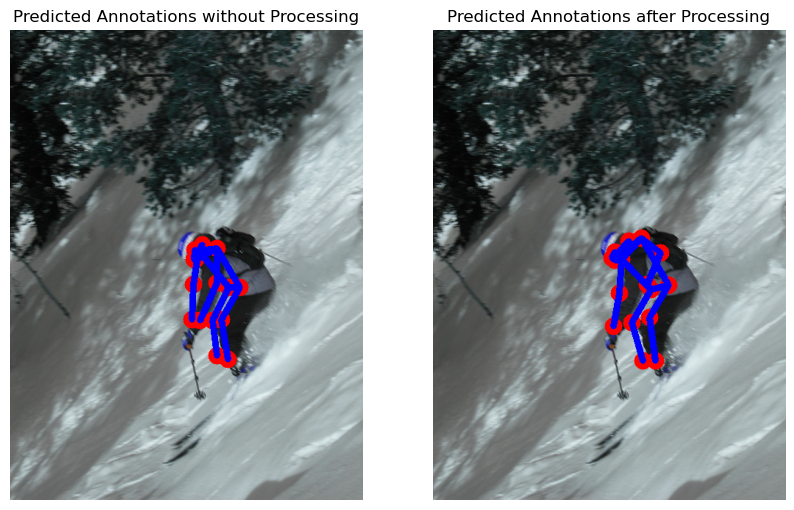

../coco2014/images/train2014/COCO_train2014_000000393223.jpg


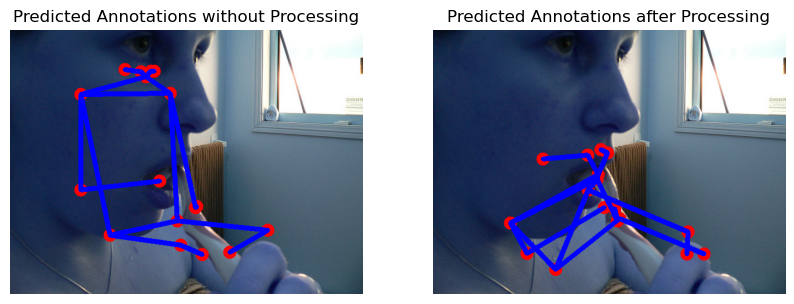

../coco2014/images/train2014/COCO_train2014_000000393224.jpg


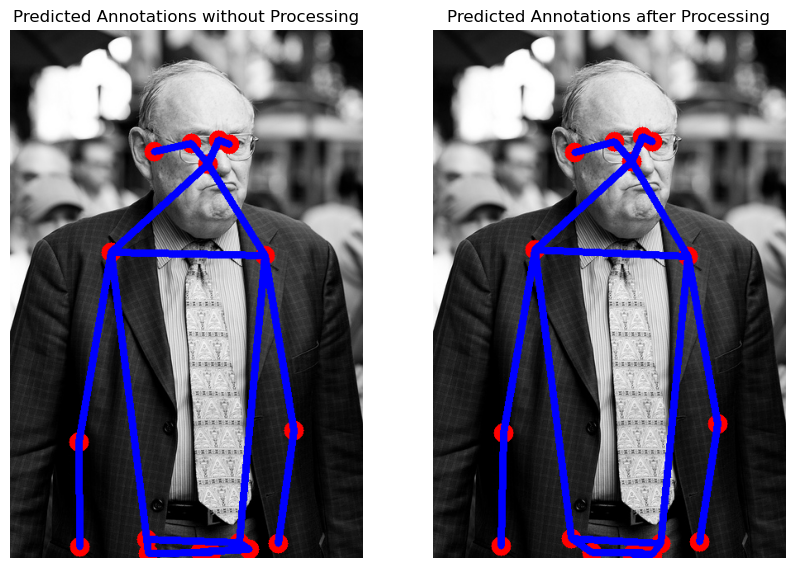

../coco2014/images/train2014/COCO_train2014_000000524297.jpg


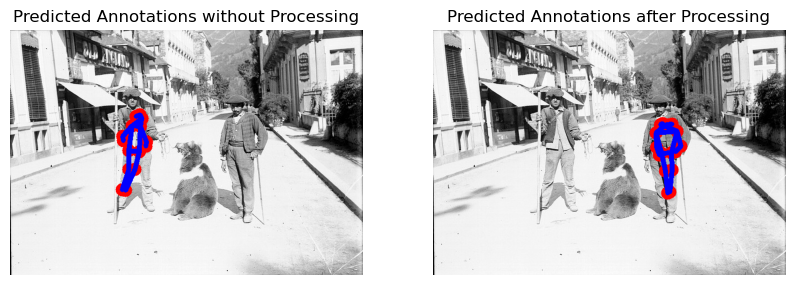

../coco2014/images/train2014/COCO_train2014_000000393227.jpg


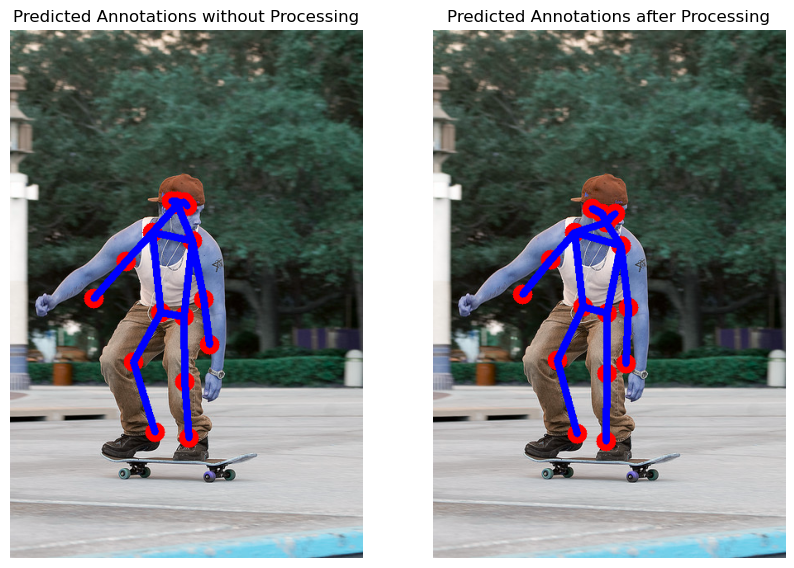

../coco2014/images/train2014/COCO_train2014_000000131084.jpg


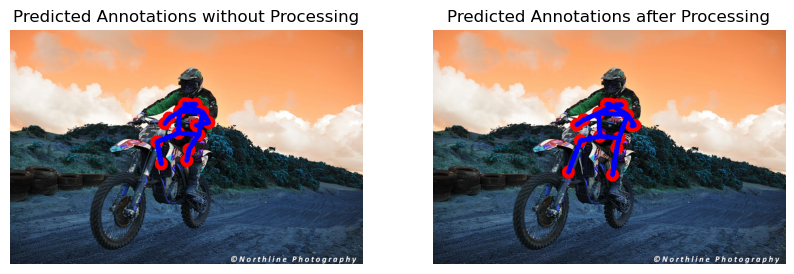

../coco2014/images/train2014/COCO_train2014_000000393230.jpg


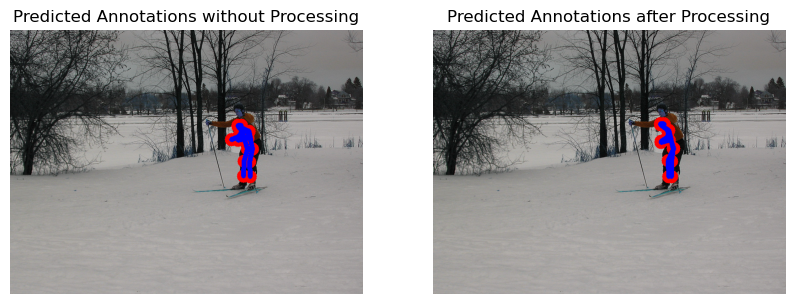

../coco2014/images/train2014/COCO_train2014_000000524311.jpg


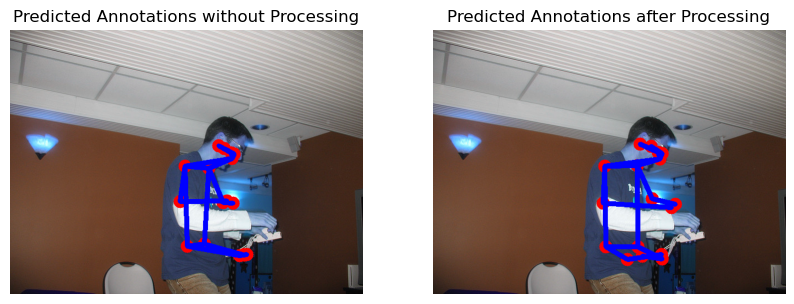

../coco2014/images/train2014/COCO_train2014_000000393241.jpg


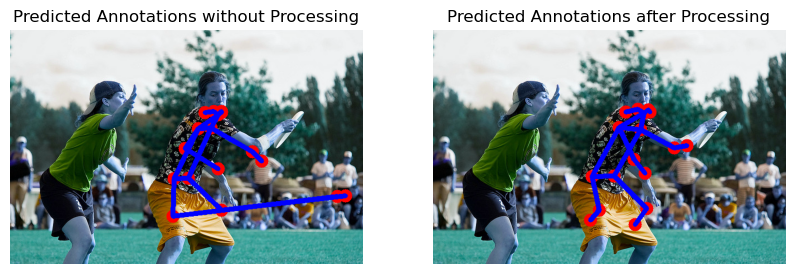

../coco2014/images/train2014/COCO_train2014_000000524314.jpg


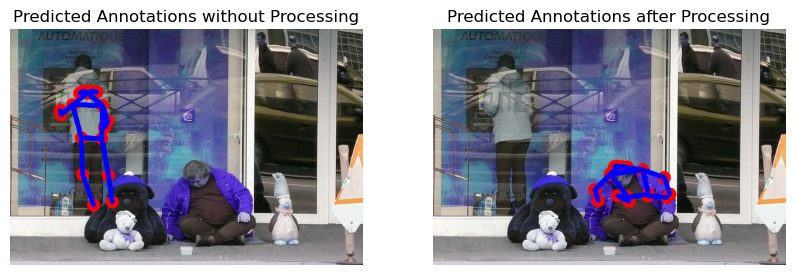

../coco2014/images/train2014/COCO_train2014_000000131101.jpg


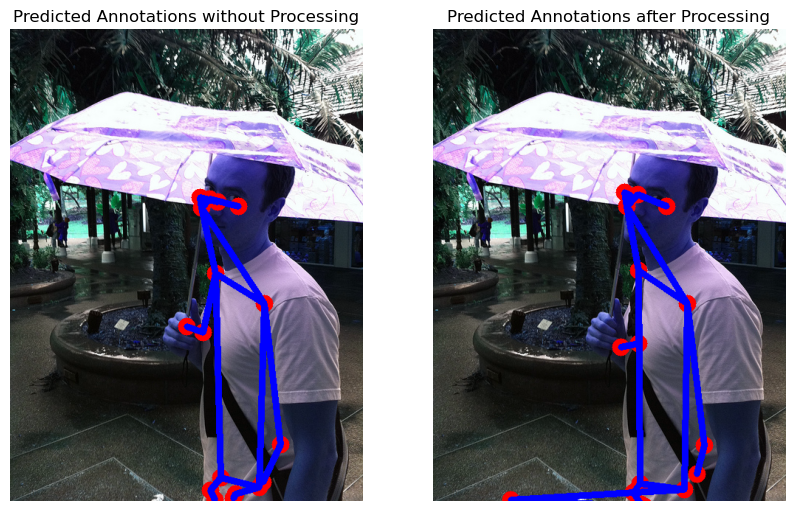

../coco2014/images/train2014/COCO_train2014_000000524320.jpg


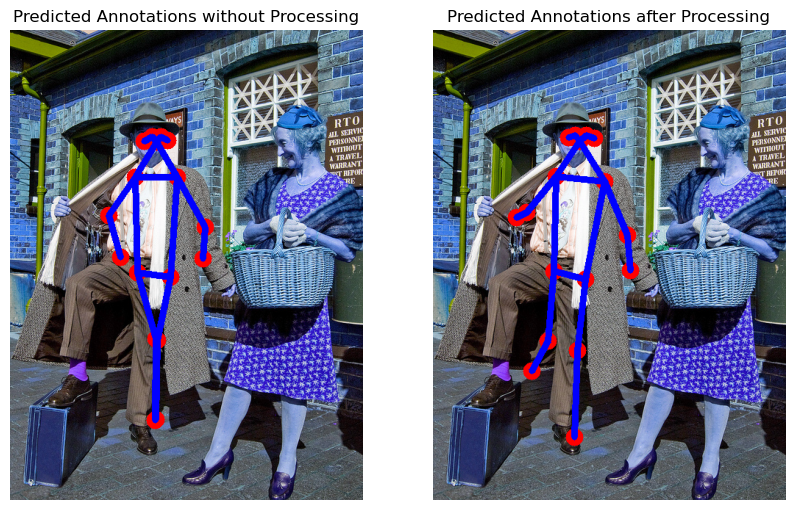

../coco2014/images/train2014/COCO_train2014_000000393251.jpg


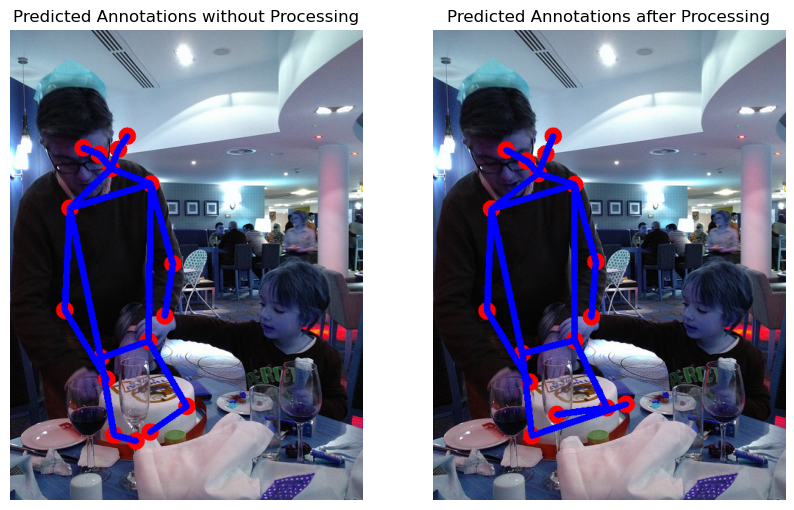

../coco2014/images/train2014/COCO_train2014_000000000036.jpg


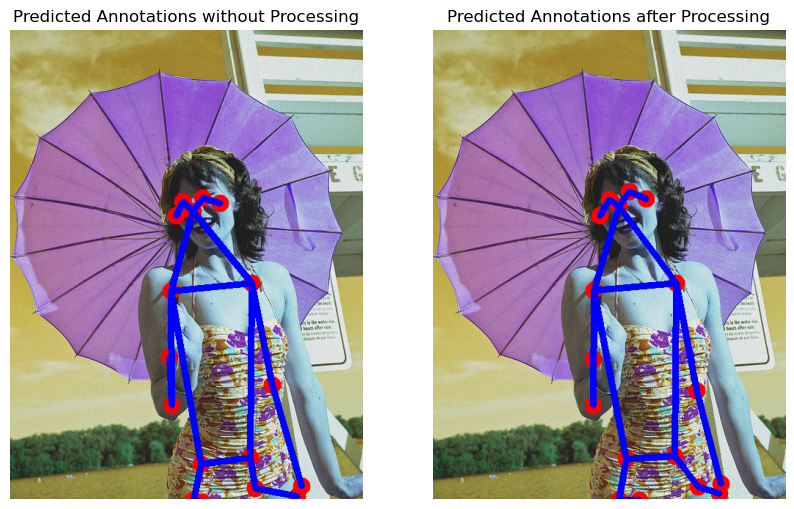

../coco2014/images/train2014/COCO_train2014_000000524338.jpg


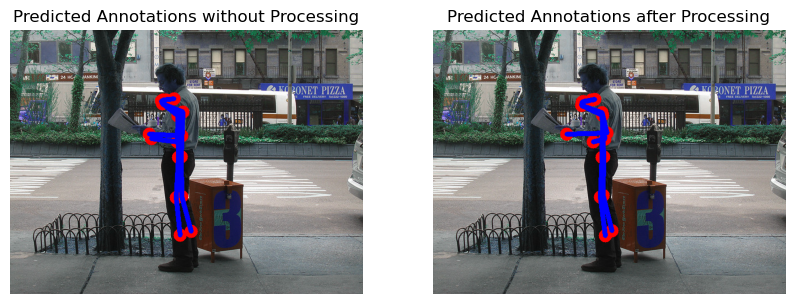

../coco2014/images/train2014/COCO_train2014_000000393268.jpg


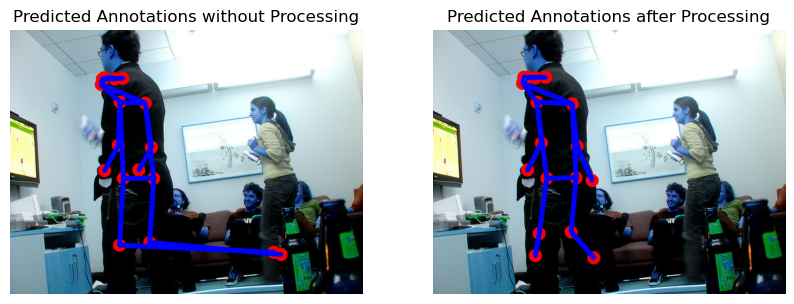

../coco2014/images/train2014/COCO_train2014_000000131127.jpg


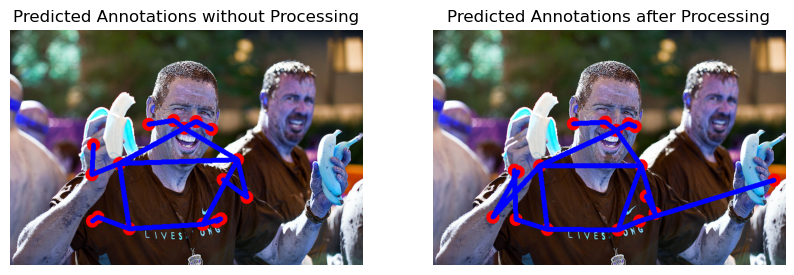

../coco2014/images/train2014/COCO_train2014_000000262207.jpg


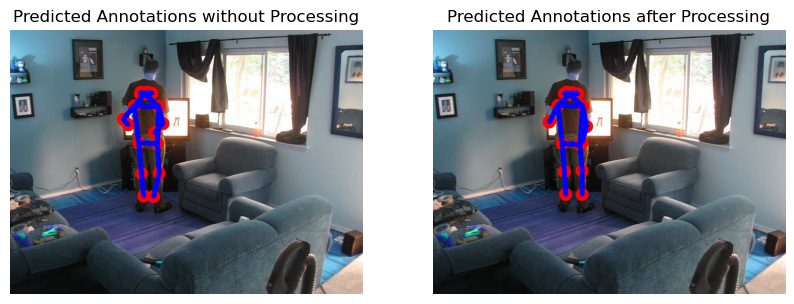

../coco2014/images/train2014/COCO_train2014_000000393290.jpg


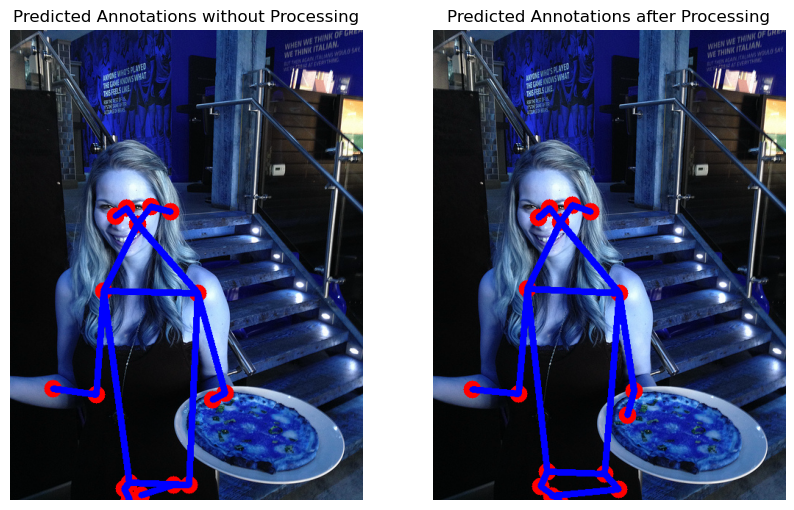

In [14]:
for static_image_path in human_image_paths:
    print(static_image_path)
    static_keypoints,original_static_keypoints = detect_pose_static(static_image_path)
    visualize_pose_static(static_image_path, static_keypoints, original_static_keypoints)